In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier
import functools

from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv("wine.csv", delimiter=";")
del(df['ash'])
X = df.loc[:, df.columns != "class"]
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [3]:
n_estimators=[10, 20, 30, 50, 100]
criterion=["gini","entropy"]
max_features=["sqrt", "auto"]
max_depth=[1,2,3,4,5,6]

scores_smote = pd.DataFrame({'n': [], 'c': [], 'mf': [], 'md':[], 'accuracy': []})
for n in n_estimators:
    for c in criterion:
        for mf in max_features:
            for md in max_depth:
                        acc = []
                        clf = RandomForestClassifier(n_estimators=n,criterion=c,max_features=mf,max_depth=md)
                        kf = StratifiedKFold(n_splits=5)
                        for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train), 1):  
                            y_train_fold = y_train.iloc[train_index]  
                            X_train_fold = X_train.iloc[train_index]
                            X_val_fold = X_train.iloc[val_index]
                            y_val_fold = y_train.iloc[val_index]  

                            sm = SMOTE()
                            X_train_fold_oversampled, y_train_fold_oversampled = sm.fit_resample(X_train_fold, y_train_fold)

                            clf.fit(X_train_fold_oversampled, y_train_fold_oversampled)  
                            y_pred_fold = clf.predict(X_val_fold)
                            acc.append(accuracy_score(y_val_fold, y_pred_fold))
                        scores_smote = scores_smote.append(pd.Series({'n': n, 'c': c, 'mf' : mf, 'md':md, 'accuracy': np.mean(acc)}), ignore_index = True)

best_config = scores_smote.iloc[scores_smote['accuracy'].idxmax()]
print(f"Best configuration WITH SMOTE:\n{best_config}")
best_n = best_config['n']
best_c = best_config['c']
best_mf = best_config['mf']
best_md = best_config['md']

Best configuration WITH SMOTE:
n              20.0
c           entropy
mf             sqrt
md              4.0
accuracy        1.0
Name: 39, dtype: object


In [4]:
best_clf =RandomForestClassifier(n_estimators=int(best_n),criterion=best_c,max_features=best_mf,max_depth=int(best_md))

sm = SMOTE()
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
best_clf.fit(X_train_oversampled, y_train_oversampled)

y_pred = best_clf.predict(X_test)
print("RANDOM FOREST EVALUATION WITH SMOTE")
print("Accuracy %f"%accuracy_score(y_test, y_pred))
print("Precision %f"%precision_score(y_test, y_pred,average="weighted",labels=np.unique(y_pred)))
print("Recall %f"%recall_score(y_test, y_pred,average="weighted",labels=np.unique(y_pred)))
print("F1-Score %f"%f1_score(y_test, y_pred,average="weighted",labels=np.unique(y_pred)))

RANDOM FOREST EVALUATION WITH SMOTE
Accuracy 0.944444
Precision 0.948232
Recall 0.944444
F1-Score 0.944781


In [5]:
n_estimators=[10, 20, 30, 50, 100]
criterion=["gini","entropy"]
max_features=["sqrt", "auto"]
max_depth=[1,2,3,4,5,6]

scores = pd.DataFrame({'n': [], 'c': [], 'mf': [], 'md':[], 'accuracy': []})
for n in n_estimators:
    for c in criterion:
        for mf in max_features:
            for md in max_depth:
                        acc = []
                        clf = RandomForestClassifier(n_estimators=n,criterion=c,max_features=mf,max_depth=md)
                        kf = StratifiedKFold(n_splits=5)
                        for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train), 1):  
                            y_train_fold = y_train.iloc[train_index]  
                            X_train_fold = X_train.iloc[train_index]
                            X_val_fold = X_train.iloc[val_index]
                            y_val_fold = y_train.iloc[val_index]  

                            clf.fit(X_train_fold, y_train_fold)  
                            y_pred_fold = clf.predict(X_val_fold)
                            acc.append(accuracy_score(y_val_fold, y_pred_fold))
                        scores = scores.append(pd.Series({'n': n, 'c': c, 'mf' : mf, 'md':md, 'accuracy': np.mean(acc)}), ignore_index = True)

best_config = scores.iloc[scores['accuracy'].idxmax()]
print(f"Best configuration WITHOUT SMOTE:\n{best_config}")
best_n = best_config['n']
best_c = best_config['c']
best_mf = best_config['mf']
best_md = best_config['md']

Best configuration WITHOUT SMOTE:
n            10.0
c            gini
mf           auto
md            6.0
accuracy    0.992
Name: 11, dtype: object


In [6]:
best_clf = RandomForestClassifier(n_estimators=int(best_n),criterion=best_c,max_features=best_mf,max_depth=int(best_md))
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)
print("RANDOM FOREST EVALUATION WITHOUT SMOTE")
print("Accuracy %f"%accuracy_score(y_test, y_pred))
print("Precision %f"%precision_score(y_test, y_pred,average="weighted",labels=np.unique(y_pred)))
print("Recall %f"%recall_score(y_test, y_pred,average="weighted",labels=np.unique(y_pred)))
print("F1-Score %f"%f1_score(y_test, y_pred,average="weighted",labels=np.unique(y_pred)))

RANDOM FOREST EVALUATION WITHOUT SMOTE
Accuracy 0.962963
Precision 0.967593
Recall 0.962963
F1-Score 0.963356


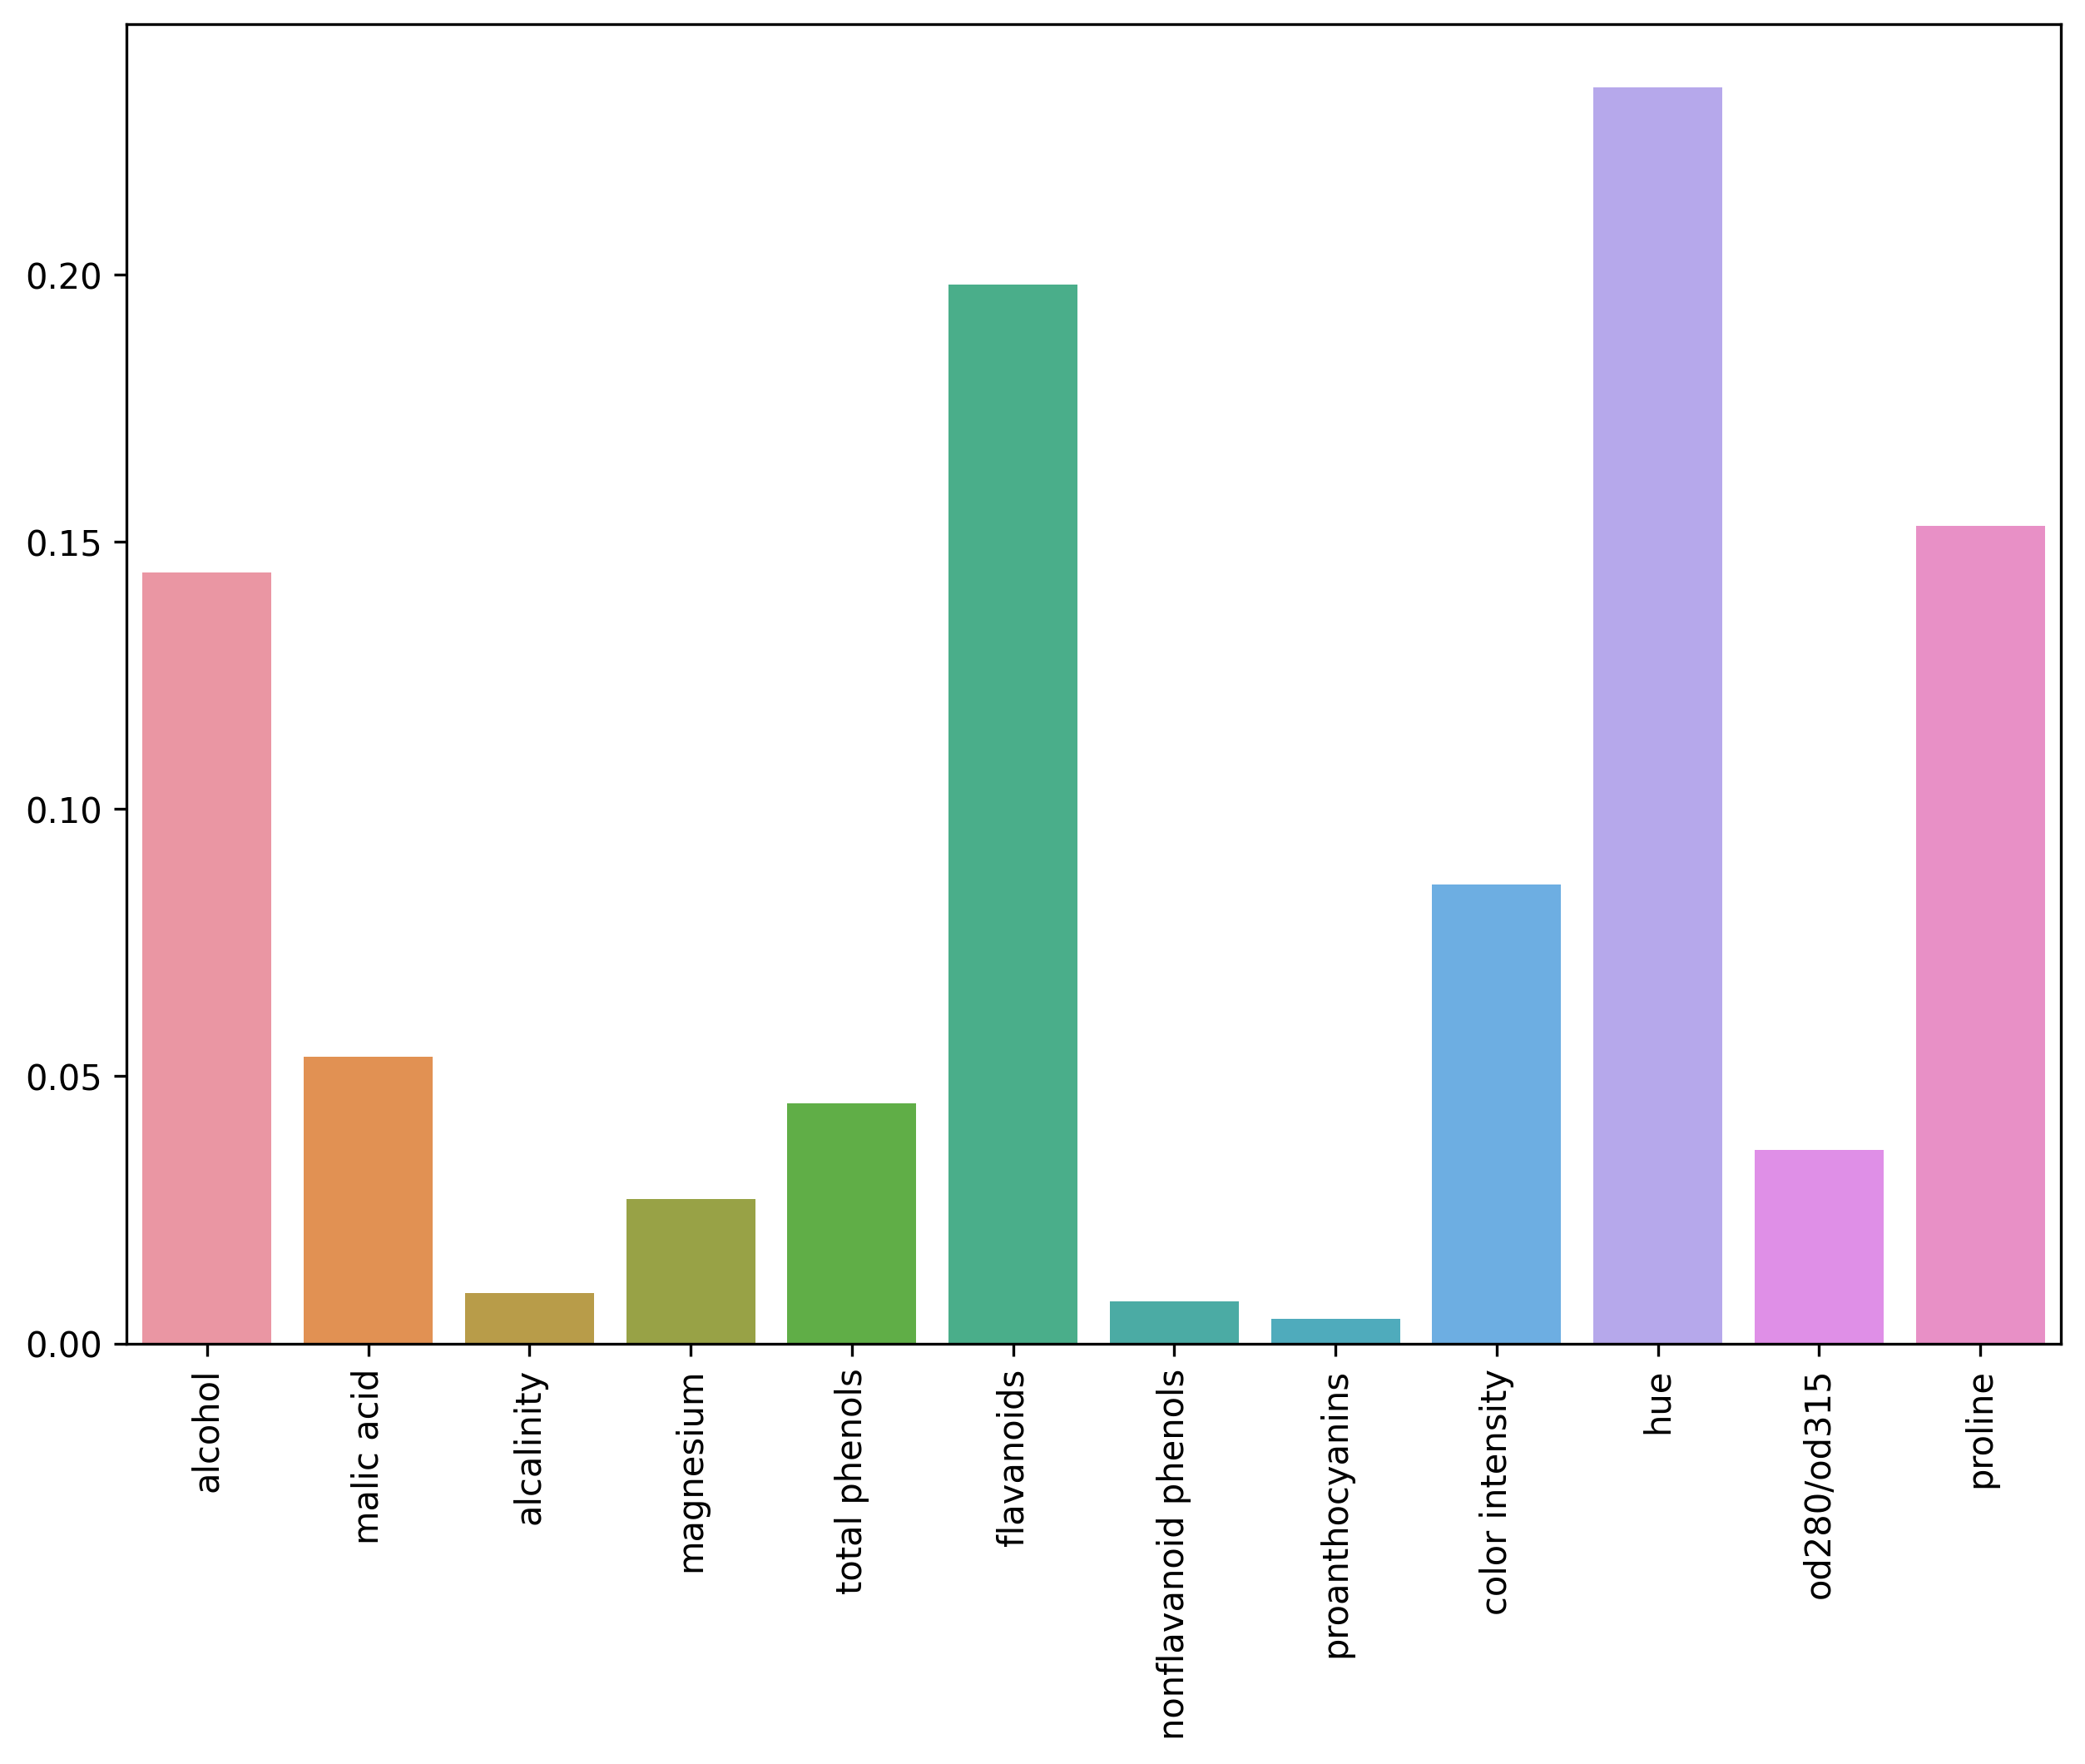

Top 5 Feature
hue
flavanoids
proline
alcohol
color intensity


In [7]:
#plot of importance per attribute
x_val = [x+1 for x in range(best_clf.feature_importances_.__len__())]
pair_val = []

for key,val in zip(x_val,best_clf.feature_importances_):
    pair_val.append([key,val])

pair_val = sorted(pair_val, key=functools.cmp_to_key(lambda x,y: y[1]-x[1]))

y_val = [x[1] for x in pair_val]
x_val = [x[0] for x in pair_val]

plt.figure(figsize=(10,7), dpi=300)

names = df.columns
ax = sns.barplot(y=y_val,x=x_val)
ax.set_xticklabels(names[1:], rotation='vertical', fontsize=10)

plt.show()

#top 5 feature
print("Top 5 Feature")
for index in x_val[0:5]:
    print(names[index])